# Import packages

In [1]:
# Pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from torchinfo import summary
#import torchmetrics

import os
import pandas as pd

import glob
import csv
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Plotting
import matplotlib.pyplot as plt

# Select device (CPU or GPU)

## Configure device

In [2]:
# Determine the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Hyperparameters

In [3]:
# The folder with the dataset
#training_folder_name = "../../data/sorted_by_mhr/training_set"
#testing_folder_name = "../../data/sorted_by_mhr/testing_set"

# The folder with the dataset
#training_folder_name = "../02_python_signal_folder_sorting/signals_by_range_and_mhr/training_set"
#testing_folder_name = "../02_python_signal_folder_sorting/signals_by_range_and_mhr/testing_set"
training_folder_name = "../../data/sorted_by_fhr/training_set"
testing_folder_name = "../../data/sorted_by_fhr/testing_set"

batch_size = 10

# Specify the channels to work with
channels = [0] # one channel
#channels = [0, 4, 8, 12, 16, 20, 24, 28, 32] # eight channels

# Specify the sample interval
sample_interval = 10
#sample_interval = 1

# Define the number of epochs
n_epochs = 1

# Define the optimiser (with its corresponding learning rate)
learning_rate = 1e-3

# The number of output clasess
#n_output_classes = 4 # output dimension
#n_output_classes = 11 # output dimension
n_output_classes = 6 # output dimension
#n_output_classes = 7 # output dimension uncomment this line when move to UNAM server

# Read the data

## Create the custom data loader

In [4]:
# Custom dataset class
class FileDataset(Dataset):
    def __init__(self, root_dir, channels, sample_interval, transform=None):
        self.root_dir = root_dir
        
        self.channels = channels
        self.sample_interval = sample_interval
        
        self.transform = transform
        self.file_list = []
        self.labels = []
        
        # The number of classes
        self.n_classes = 0

        # Extract file paths and labels
        self._extract_file_paths()
        
         # Perform label encoding as one-hot encoding
        self._encode_labels()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        label = self.labels[idx]

        # Read the file
        data = self._read_file(file_path)

        # Apply transformation if provided
        if self.transform:
            data = self.transform(data)

        return data, label

    def _extract_file_paths(self):
        label_dirs = os.listdir(self.root_dir)

        for label in label_dirs:
            label_dir = os.path.join(self.root_dir, label)
            if os.path.isdir(label_dir):
                files = glob.glob(os.path.join(label_dir, '*.csv'))
                self.file_list.extend(files)
                self.labels.extend([label] * len(files))

    def _read_file(self, file_path):
        
        signal_data = np.loadtxt(file_path, dtype=np.float32, delimiter=",")
        # Transform to torch vector and reshape to column vector
        return torch.from_numpy(signal_data)
        
        # Implement your own file reading logic here
        # For example, if you're working with CSV files, you can use pandas
        # dataframe = pd.read_csv(file_path)
        # return dataframe.values

        # In this example, we assume a simple text file and read its content
        #with open(file_path, 'r') as file:
        #    content = file.read()

        #return content
        
    def _encode_labels(self):
        
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(self.labels)
        
        # Print the original classes names
        #print(label_encoder.classes_)
        
        # Reshape to column vector
        integer_encoded = integer_encoded.reshape(-1, 1)

        # JCPS "sparse" deprecated in version 1.2, use "sparse_output" from version 1.4
        #onehot_encoder = OneHotEncoder(sparse=False)
        onehot_encoder = OneHotEncoder(sparse_output=False)
        
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        
        self.n_classes = onehot_encoded.shape[1]
        
        self.labels = torch.tensor(onehot_encoded, dtype=torch.float32)
        #self.labels = torch.tensor(onehot_encoded, dtype=torch.long)


## Define transformations for the raw data

In [5]:
# Reshape the raw data to a row vector

class ToRowVector(object):
    """Transforms the input signal to a row vector"""
    
    def __call__(self, sample):
        #reshaped_sample = sample.view(1, -1)
        #print(sample.shape[0])
        #print(sample.shape[1])
        
        # Slide the data, use only the first row
        preshaped = sample[0,:]
                        
        #reshaped_sample = sample.view(sample.shape[0]*sample.shape[1])
        reshaped_sample = preshaped.view(preshaped.shape[0])
        
        #return sample
        return reshaped_sample

# Subsample signal extracting only selected channels and gor a given sample interval
class SignalSubSample(object):
    
    def __init__(self, channels, sample_interval):
        """
        Initialize input arguments.
        """
        self.channels = channels
        self.sample_interval = sample_interval
    
    def __call__(self, sample):
            
        # Get the indices of the columns to extract
        indexes_columns = list(range(0, sample.shape[1], sample_interval))  # Select every "sample_interval" column
        
        # Extract selected channels and rows
        subsample_signal = sample[channels, :][:, indexes_columns]                
        
        #print(subsample_signal.shape)
                               
        #return sample
        return subsample_signal

## Instantiate the data loader

In [6]:
# Create training datasets
training_dataset = FileDataset(training_folder_name, channels, 
                            sample_interval, 
                            transform=transforms.Compose([
                                SignalSubSample(channels, sample_interval)#,
                                #transforms.Normalize((0.1), (0.1))
                            ]))

# Create testing datasets
testing_dataset = FileDataset(testing_folder_name, channels, 
                            sample_interval, 
                            transform=transforms.Compose([
                                SignalSubSample(channels, sample_interval)#,
                                #transforms.Normalize(mean=[0.1], std=[0.01])
                            ]))

#train_dataset = FileDataset(folder_name, channels, 
#                            sample_interval, 
#                            transform=transforms.Compose([
#                                ToRowVector()
#                            ]))
#train_dataset = FileDataset(folder_name)
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)
print("Train loader: Total number of batches {} using {} items per batch. Total samples {}".format(len(train_loader), batch_size, len(train_loader) * batch_size))
print("Test loader: Total number of batches {} using {} items per batch. Total samples {}".format(len(test_loader), batch_size, len(test_loader) * batch_size))

Train loader: Total number of batches 109 using 10 items per batch. Total samples 1090
Test loader: Total number of batches 28 using 10 items per batch. Total samples 280


# Define the Neural Network

In [7]:
# Define the neural network architecture
class BaseClassifier(nn.Module):
    def __init__(self, n_input_data_x, n_input_data_y, n_output):
        super(BaseClassifier, self).__init__()
           
        # Define your layers here   
        
        #self.linear1 = nn.Linear(in_dim, 1024, bias=True)
        #self.linear2 = nn.Linear(1024, 256)
        #self.relu = nn.ReLU()
        #self.linear3 = nn.Linear(256, out_dim)
     
        input_features = n_input_data_x * n_input_data_y
    
        self.linear1 = nn.Linear(input_features, 128, bias=True)
        self.linear2 = nn.Linear(128, 32)
        self.relu = nn.ReLU()
        self.linear3 = nn.Linear(32, n_output)

    def forward(self, x):
        
        #print("Before the flattening")
        #print(x.shape[0])
        #print(x.shape[1])
        #print(x.shape)
        
        # Perform the flattening of the input data to pass through the linear layers
        #reshaped_sample = sample.view(sample.shape[0]*sample.shape[1])
        x = x.view(x.shape[0], -1)
        
        #print("After the flattening")
        #print(x.shape[0])
        #print(x.shape[1])
        #print(x.shape)
        
        # Define the forward pass of your networkloss.item())
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
                
        return x

# Instantiate the optimiser and model

## Optimiser and model

In [8]:
# Get the number of channels on the processing signal
n_channels = len(channels)

# Original number of data per channel
n_original_data_per_channel = 60000

# Get the number of data per channel
n_data_per_channel = n_original_data_per_channel // sample_interval # Integer division

#n_input_features = 2040000
n_input_features = n_channels * n_data_per_channel # input dimension
print("Number of input feautres: {}\n".format(n_input_features))

# Create an instance of the neural network and move it to the device
net = BaseClassifier(n_channels, n_data_per_channel, n_output_classes).to(device)

#net.cuda()
#net.cpu()

# Define the loss function
# Cross-entropy
criterion = nn.CrossEntropyLoss()

# Mean Square Error
#criterion = nn.MSELoss()

# Use Adam optimiser
opt = optim.Adam(net.parameters(), lr=learning_rate)

# Stochastic Gradient Descent
#opt = optim.SGD(net.parameters(), lr=learning_rate)

# Summary of the model
for p in net.parameters():
    print(p.shape)

# Summary of the model
#summary(net, input_size = (batch_size, 2040000, 4))
summary(net, input_size = (batch_size, n_input_features))
#summary(net)

Number of input feautres: 6000

torch.Size([128, 6000])
torch.Size([128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([6, 32])
torch.Size([6])


Layer (type:depth-idx)                   Output Shape              Param #
BaseClassifier                           [10, 6]                   --
├─Linear: 1-1                            [10, 128]                 768,128
├─ReLU: 1-2                              [10, 128]                 --
├─Linear: 1-3                            [10, 32]                  4,128
├─ReLU: 1-4                              [10, 32]                  --
├─Linear: 1-5                            [10, 6]                   198
Total params: 772,454
Trainable params: 772,454
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 7.72
Input size (MB): 0.24
Forward/backward pass size (MB): 0.01
Params size (MB): 3.09
Estimated Total Size (MB): 3.34

## Helper functions

In [9]:
# Define a helper function to generate a one-hot encoding at the position of the maximum value
def generate_max_indices_tensor(input_tensor):
    # Compute the maximum along each row
    max_values, max_indices = torch.max(input_tensor, dim=1)
    
    # Create a tensor of zeros with the same shape as the input tensor
    output_tensor = torch.zeros_like(input_tensor)
    
    # Set ones at the indices of the maximum values
    output_tensor.scatter_(1, max_indices.unsqueeze(1), 1)
    
    return output_tensor

# Define a helper function that returns a one tensor if the input tensors are equal
def compare_tensors(tensor1, tensor2):
    
    # Ensure both tensors have the same shape
    assert tensor1.shape == tensor2.shape, "Both tensors should have the same dimensions."

    # Calculate element-wise equality and count equal rows
    row_equality = torch.all(tensor1 == tensor2, dim=1)
    equal_rows = torch.sum(row_equality).item()

    # Count different rows
    different_rows = tensor1.shape[0] - equal_rows
    
    return torch.tensor([equal_rows, different_rows])

# Train the model

Epoch [1/1], batch [1/109], lr=0.001000, batch Loss: 87.4862, batch accuracy: 10.0000
Epoch [1/1], batch [2/109], lr=0.001000, batch Loss: 40.8402, batch accuracy: 30.0000
Epoch [1/1], batch [3/109], lr=0.001000, batch Loss: 33.3214, batch accuracy: 40.0000
Epoch [1/1], batch [4/109], lr=0.001000, batch Loss: 71.8866, batch accuracy: 20.0000
Epoch [1/1], batch [5/109], lr=0.001000, batch Loss: 57.4193, batch accuracy: 0.0000
Epoch [1/1], batch [6/109], lr=0.001000, batch Loss: 67.1157, batch accuracy: 20.0000
Epoch [1/1], batch [7/109], lr=0.001000, batch Loss: 69.7890, batch accuracy: 20.0000
Epoch [1/1], batch [8/109], lr=0.001000, batch Loss: 59.2528, batch accuracy: 20.0000
Epoch [1/1], batch [9/109], lr=0.001000, batch Loss: 26.6748, batch accuracy: 20.0000
Epoch [1/1], batch [10/109], lr=0.001000, batch Loss: 42.5280, batch accuracy: 30.0000
Epoch [1/1], batch [11/109], lr=0.001000, batch Loss: 40.9071, batch accuracy: 50.0000
Epoch [1/1], batch [12/109], lr=0.001000, batch Loss:

Epoch [1/1], batch [96/109], lr=0.001000, batch Loss: 12.2708, batch accuracy: 10.0000
Epoch [1/1], batch [97/109], lr=0.001000, batch Loss: 3.7025, batch accuracy: 20.0000
Epoch [1/1], batch [98/109], lr=0.001000, batch Loss: 5.2211, batch accuracy: 10.0000
Epoch [1/1], batch [99/109], lr=0.001000, batch Loss: 6.1824, batch accuracy: 10.0000
Epoch [1/1], batch [100/109], lr=0.001000, batch Loss: 2.7064, batch accuracy: 20.0000
Epoch [1/1], batch [101/109], lr=0.001000, batch Loss: 11.4186, batch accuracy: 10.0000
Epoch [1/1], batch [102/109], lr=0.001000, batch Loss: 5.9853, batch accuracy: 10.0000
Epoch [1/1], batch [103/109], lr=0.001000, batch Loss: 4.5526, batch accuracy: 40.0000
Epoch [1/1], batch [104/109], lr=0.001000, batch Loss: 5.8273, batch accuracy: 20.0000
Epoch [1/1], batch [105/109], lr=0.001000, batch Loss: 2.5662, batch accuracy: 20.0000
Epoch [1/1], batch [106/109], lr=0.001000, batch Loss: 8.0473, batch accuracy: 20.0000
Epoch [1/1], batch [107/109], lr=0.001000, ba

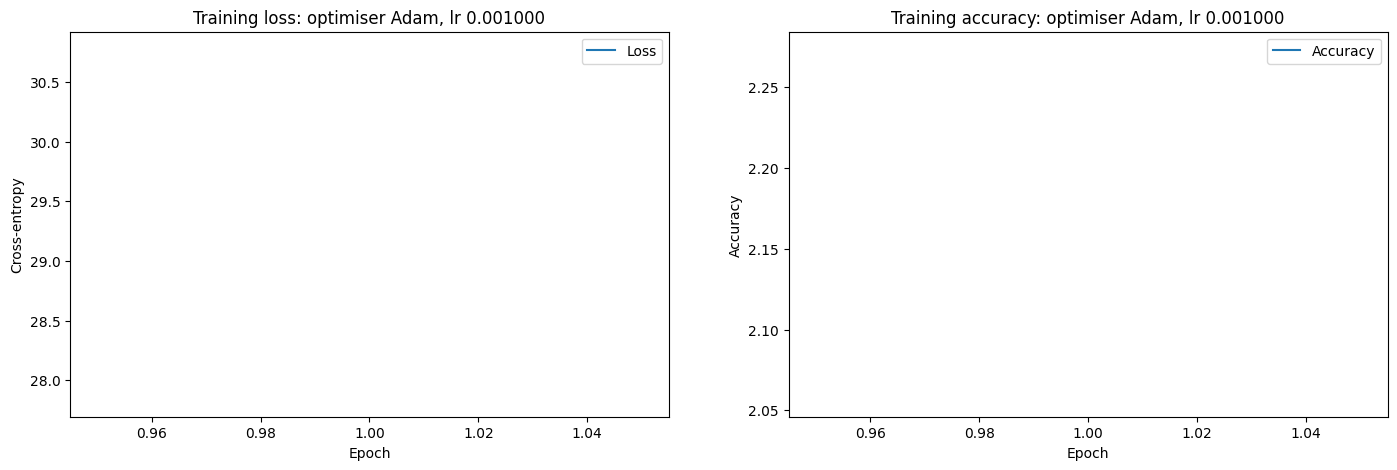

In [13]:
# Define the training method
def train(model=net,
          optimizer=opt,
          n_epochs=n_epochs,
          loss_fn=criterion,
          lr=learning_rate):
    
    #accuracy_metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes = n_output_classes)
    
    # Indicate the Pytorch backend we are on training mode
    model.train()
    loss_lt = []
    accuracy_lt = []
    
    # Training loop
    for epoch in range(n_epochs):
        running_loss = 0.0
        accuracy_epoch = 0.0
        batch_counter = 0
        for batch_data, batch_labels in train_loader:
        
            # Prior any operation clear the gradient
            optimizer.zero_grad()
        
            # Move data and labels to the device
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
        
            # Forward pass
            outputs = model(batch_data)

            #print("Outputs\n")
            #print(outputs)
        
            #print("Batch labels\n")
            #print(batch_labels)
        
            # Apply the loss function
            loss = loss_fn(outputs, batch_labels)
            
            # Backpropagation and optimization
            loss.backward()
        
            # Perform an optimization step (this updates the weights and bias on the network)
            optimizer.step()
                    
            # Keep track of sum of loss of each batch
            running_loss+=loss.item()
            
             # Compute the one-hot enconding version
            one_hot_output = generate_max_indices_tensor(outputs)
                   
            # Compute accuracy
            batch_accuracy = compare_tensors(one_hot_output, batch_labels)[0]
            
            # Keep track of accuracy
            accuracy_epoch+=batch_accuracy
            
            # Metrics
            #acc = accuracy_metric(outputs, batch_labels)
            
            # Print the loss for monitoring
            print('Epoch [{}/{}], batch [{}/{}], lr={:.6f}, batch Loss: {:.4f}, batch accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                                batch_counter + 1, len(train_loader),
                                                                                                                lr, loss.item(),
                                                                                                                batch_accuracy*100.0/batch_size))
            #print("Torch Metrics: {}".format(acc))
            
            # Increase the batch counter
            batch_counter += 1
        
        # Add the cumulative loss to a list
        loss_lt.append(running_loss/len(train_loader))
        
        # Add the cumulative accuracy to a list
        accuracy_lt.append(accuracy_epoch/len(train_loader)) 
        
        # Print the total loss of the epoch
        print('Epoch: {} training loss: {:.4f}, training accuracy: {:.4f}'.format(epoch+1, running_loss/len(train_loader), accuracy_epoch/len(train_loader)))
        
        #acc = accuracy_metric.compute()
        #print("All batches torch metric: {}".format(acc))
    
    #accuracy_metric.reset()
    
    fig = plt.figure(figsize=(17, 5))
    ax1 = plt.subplot(121)
    ax1.plot([i for i in range(1, n_epochs+1)], loss_lt, label="Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Cross-entropy")
    ax1.set_title("Training loss: optimiser {}, lr {:.6f}".format("Adam", lr))
    ax1.legend()
    
    ax2 = plt.subplot(122)
    ax2.plot([i for i in range(1, n_epochs+1)], accuracy_lt, label="Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Training accuracy: optimiser {}, lr {:.6f}".format("Adam", lr))
    ax2.legend()
    
    plt.show()

# Save the trained model
#torch.save(net.state_dict(), "./trained_model/model.pt')

# Call the training method
train(net, opt, n_epochs, criterion)

# Test the model

In [14]:
# Define the testing method
def test(model=net,
        loss_fn=criterion,
        lr=learning_rate):
    
    # Indicate the Pytorch backend we are on testing mode
    model.eval()
    accuracy = 0.0
    total_loss = 0.0 
    
    # Use no grad to reduce memory and computation cost
    with torch.no_grad():
        
        batch_counter = 0
        for batch_data, batch_labels in test_loader:
            
            # Move data and labels to the device
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            # Forward pass
            outputs = model(batch_data)
            
            #print("These are the outputs")
            #print(outputs)
            
            #print("These are the batch labels")
            #print(batch_labels)
            
            # Compute the loss
            batch_loss = loss_fn(outputs, batch_labels)
            
            # Add up the loss
            total_loss+=batch_loss.item()
            
            # Compute the one-hot enconding version
            one_hot_output = generate_max_indices_tensor(outputs)
            
            #print("These are the one-hot outputs")
            #print(one_hot_output)
            
            # Compute accuracy
            batch_accuracy = compare_tensors(one_hot_output, batch_labels)[0]
            #batch_accuracy = torch.sum(compare_tensors(one_hot_output, batch_labels))
            #print(compare_tensors(one_hot_output, batch_labels))
            
            accuracy+=batch_accuracy
            
            print("Test batch [{}/{}], lr={:.6f},  batch loss: {:.4f}, test batch accuracy: {:.4f}".format(
                batch_counter + 1, len(test_loader), lr, 
                batch_loss/batch_size,
                batch_accuracy*100.0/batch_size))
            
            # Increase the batch counter
            batch_counter += 1
            
        print("Test loss: {:.4f}, test accuracy: {:.4f}".format(
            total_loss/(len(test_loader)*batch_size),
            accuracy*100.0/(len(test_loader)*batch_size)))

# Call the test method
test(net, criterion)

Test batch [1/28], lr=0.001000,  batch loss: 0.7596, test batch accuracy: 10.0000
Test batch [2/28], lr=0.001000,  batch loss: 0.8376, test batch accuracy: 0.0000
Test batch [3/28], lr=0.001000,  batch loss: 0.6482, test batch accuracy: 10.0000
Test batch [4/28], lr=0.001000,  batch loss: 0.6888, test batch accuracy: 10.0000
Test batch [5/28], lr=0.001000,  batch loss: 0.5504, test batch accuracy: 10.0000
Test batch [6/28], lr=0.001000,  batch loss: 1.3495, test batch accuracy: 0.0000
Test batch [7/28], lr=0.001000,  batch loss: 0.2443, test batch accuracy: 10.0000
Test batch [8/28], lr=0.001000,  batch loss: 0.5535, test batch accuracy: 10.0000
Test batch [9/28], lr=0.001000,  batch loss: 0.5870, test batch accuracy: 0.0000
Test batch [10/28], lr=0.001000,  batch loss: 0.7657, test batch accuracy: 10.0000
Test batch [11/28], lr=0.001000,  batch loss: 0.4722, test batch accuracy: 10.0000
Test batch [12/28], lr=0.001000,  batch loss: 0.4379, test batch accuracy: 10.0000
Test batch [13/2

# Code testing

In [ ]:
for batch_data, batch_labels in train_loader:
    print(batch_data.shape)
    print(batch_labels)
    print(batch_labels.shape)

In [ ]:
signal_data = np.loadtxt("../02_python_signal_folder_sorting/sorted_signals_by_mhr/70_74/nifecg.0003.fs_1000_mhr_72_fhr_132.csv", dtype=np.float32, delimiter=",")
signal_data_torch = torch.from_numpy(signal_data)
signal_data_torch

In [ ]:
## One-hot enconding
encoder = OneHotEncoder

In [ ]:
x = torch.rand(3,4)
print(x)
idx, x_max = x.max(dim=1)
print(x_max)
x_arg_max = torch.argmax(x, 1)
print(x_arg_max)

In [ ]:
# Determine the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device